In [1]:
import os
import json
import numpy as np
from typing import Deque, Iterable, List, Sequence
from collections import deque
from pathlib import Path
import matplotlib.pyplot as plt

data_folder = Path("data")
data_folder.absolute()


PosixPath('/pscratch/sd/j/jundac/project/d2/benchmarks/_250630_new_simulator2/data')

In [2]:
def sample_wlbllm_docs_upsample(
    *,
    size: int,
    seed: int = 42,
    filter_threshold: int = 10000,
    filter_ratio: float = 1.0,
    upsample_long_factor: float = 1.0,
) -> list[int]:
    """
    Sample `size` documents from the WLB-LLM distribution, upsampling long docs.

    Parameters
    ----------
    size : int
        Number of documents to sample.
    seed : int
        RNG seed.
    filter_threshold : int
        Token count threshold separating short and long docs.
    filter_ratio : float
        Fraction of short docs to keep (for downsampling).
    upsample_long_factor : float
        Multiplicative upsampling factor for long docs (≥ threshold).

    Returns
    -------
    list[int]
        A list of sampled document lengths.
    """
    docpath = data_folder / "dist_wlbllm.json"
    with open(docpath, "r") as f:
        docs = json.load(f)

    shorter_docs = [doc for doc in docs if doc < filter_threshold]
    longer_docs = [doc for doc in docs if doc >= filter_threshold]

    # Downsample short docs
    if 0 < filter_ratio < 1.0:
        shorter_docs = shorter_docs[:int(len(shorter_docs) * filter_ratio)]

    # Upsample long docs
    if upsample_long_factor > 1.0:
        longer_docs = longer_docs * int(upsample_long_factor)

    combined_docs = shorter_docs + longer_docs

    rng = np.random.default_rng(seed)
    sampled_docs = rng.choice(combined_docs, size=size, replace=False)
    return sampled_docs.tolist()

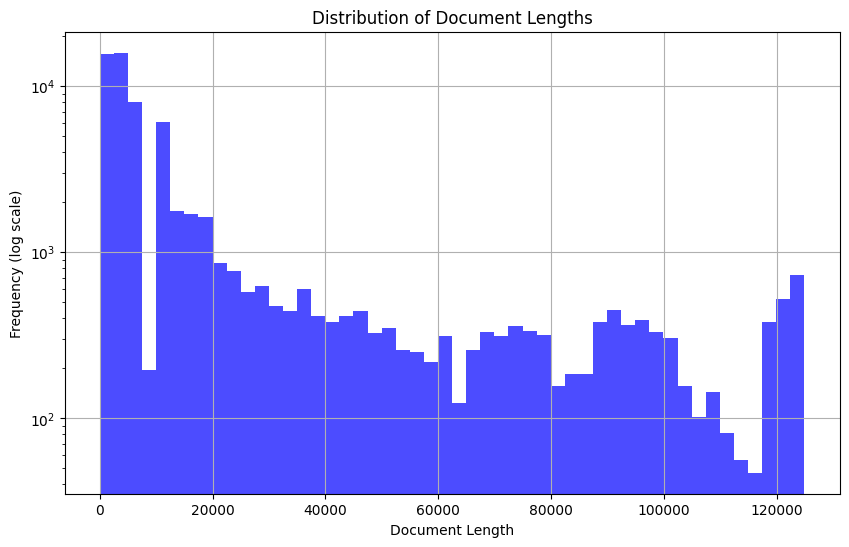

In [3]:
docs = sample_wlbllm_docs_upsample(
    size=64 * 1024,
    upsample_long_factor=32.0
)

# Plot the document lengths
plt.figure(figsize=(10, 6))
plt.hist(docs, bins=50, color='blue', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()


In [4]:
import wandb

In [5]:
from samples import batch_documents

In [38]:
import wandb
from samples import sample_wlbllm_docs_upsample
K = 1024
batch_size = K * 64
sample_size = 2000
filter_threshold = 10000
filter_ratio = 1.0
upsample_long_factor = 16

docs = sample_wlbllm_docs_upsample(
    size=sample_size,
    upsample_long_factor=upsample_long_factor,
    filter_threshold=filter_threshold,
    filter_ratio=filter_ratio,
)
batches = batch_documents(docs, max_ctx_length=batch_size)
batches = list(batches)

short_doc_count = len([doc for doc in docs if doc < filter_threshold])
long_doc_count = len([doc for doc in docs if doc >= filter_threshold])
short_doc_tokens = sum([doc for doc in docs if doc < filter_threshold])
long_doc_tokens = sum([doc for doc in docs if doc >= filter_threshold])

doc_ratio = 100 * long_doc_count / (short_doc_count + long_doc_count)
token_ratio = 100 * long_doc_tokens / (short_doc_tokens + long_doc_tokens)
print(f"short_doc_count: {short_doc_count}, long_doc_count: {long_doc_count}, long/total: {doc_ratio:.2f}%")
print(f"short_doc_tokens: {short_doc_tokens}, long_doc_tokens: {long_doc_tokens}, long/total: {token_ratio:.2f}%")

short_doc_count: 1497, long_doc_count: 503, long/total: 25.15%
short_doc_tokens: 4608702, long_doc_tokens: 22195748, long/total: 82.81%


In [39]:

run = wandb.init(
    project="doc-wlbllm-upsample",
    name=f"wlb-f{upsample_long_factor}-bs{batch_size}-ss{sample_size}",
)

run.config.update({
    "upsample_long_factor": upsample_long_factor,
    "batch_size": batch_size,
    "sample_size": sample_size,
    "upsample_long_factor": upsample_long_factor,
})

table = wandb.Table(columns=[
    "long_doc_count", "short_doc_count", "long_doc_tokens", "short_doc_tokens", 
    "long_doc_count_over_all_ratio", "long_doc_tokens_over_all_ratio", 
    "batch_size", "total_tokens", "batch"
])

for batch in batches:
    print(batch)
    long_doc_count = sum(1 for doc in batch if doc >= 10000)
    short_doc_count = sum(1 for doc in batch if doc < 10000)
    long_doc_tokens = sum(doc for doc in batch if doc >= 10000)
    short_doc_tokens = sum(doc for doc in batch if doc < 10000)
    long_doc_count_over_all_ratio = (long_doc_count) / (long_doc_count + short_doc_count)
    long_doc_tokens_over_all_ratio = (long_doc_tokens) / (long_doc_tokens + short_doc_tokens)
    total_tokens = sum(batch)
    run.log({
        "long_doc_count": long_doc_count,
        "short_doc_count": short_doc_count,
        "long_doc_tokens": long_doc_tokens,
        "short_doc_tokens": short_doc_tokens,
        "long_doc_count_over_all_ratio": long_doc_count_over_all_ratio,
        "long_doc_tokens_over_all_ratio": long_doc_tokens_over_all_ratio,
        "batch_size": len(batch),
        "total_tokens": total_tokens,
    })
    table.add_data(long_doc_count, short_doc_count, long_doc_tokens, short_doc_tokens, 
                   long_doc_count_over_all_ratio, long_doc_tokens_over_all_ratio, 
                   len(batch), total_tokens, batch)


run.log({"table": table})

short_doc_count = len([doc for doc in docs if doc < filter_threshold])
long_doc_count = len([doc for doc in docs if doc >= filter_threshold])
short_doc_tokens = sum([doc for doc in docs if doc < filter_threshold])
long_doc_tokens = sum([doc for doc in docs if doc >= filter_threshold])

doc_ratio = 100 * long_doc_count / (short_doc_count + long_doc_count)
token_ratio = 100 * long_doc_tokens / (short_doc_tokens + long_doc_tokens)
run.summary.update({
    "long_doc_count": long_doc_count,
    "short_doc_count": short_doc_count,
    "long_doc_tokens": long_doc_tokens,
    "short_doc_tokens": short_doc_tokens,
    "long_doc_count_over_all_ratio": doc_ratio,
    "long_doc_tokens_over_all_ratio": token_ratio,
})
run.finish()

[3262, 1996, 2516, 26250, 31512]
[44077, 4526, 5873, 1539, 9521]
[3401, 4621, 3432, 15504, 35429, 3149]
[1799, 1555, 644, 253, 2982, 25684, 3402, 29217]
[62436, 3100]
[8917, 4490, 25207, 559, 1966, 3438, 2168, 627, 6231, 4153, 101, 1889, 5419, 371]
[5255, 614, 2709, 15978, 2545, 38435]
[54917, 10619]
[1621, 1971, 61944]
[58234, 6182, 1120]
[4026, 3994, 273, 5606, 51637]
[13731, 614, 1439, 4199, 1184, 3491, 5772, 6218, 2046, 3231, 524, 5506, 4429, 1440, 832, 2109, 1791, 6980]
[65536]
[27648, 3369, 303, 11345, 22871]
[55446, 4419, 5671]
[65536]
[50396, 5752, 6103, 3285]
[141, 4380, 61015]
[14556, 50980]
[28786, 2538, 4547, 5396, 328, 4405, 5145, 10196, 4195]
[9821, 457, 12885, 582, 41791]
[63467, 2069]
[2438, 2593, 5675, 460, 3444, 4330, 1718, 1326, 43552]
[47895, 17641]
[63020, 2516]
[65536]
[53445, 4620, 1636, 4061, 1774]
[65536]
[33819, 2235, 649, 3905, 5260, 1293, 4611, 13764]
[27776, 313, 5951, 3137, 27145, 1214]
[3429, 35525, 2032, 207, 234, 6199, 3485, 5936, 1685, 6804]
[11283, 61

batch_size,▇▁▄▁▅▄▄▄▁▅▄▄▁▄▃▂▂▂▅▁▃▅▄▅▄▁▄▂▁▁█▁▁▃▃▅▁▂▄▁
long_doc_count,▁▁▅▅▁▁▅▅▁▅▅▁▁█▁█▅▅▅▁█▁▅▁▁▅▁▁▁▁▁▁▁▅▁▅▁█▁▁
long_doc_count_over_all_ratio,█▂▂▃▄█▄▂█▆▃▃▃▂▄▄▆▁▂▆█▂█▄▂▃▃▃█▂▃▄▄▃██▄▂▁▄
long_doc_tokens,█▅█▄▆▇▃▅▅▁▄█▇██▅▅▇▇▆█▄▆▆█▄█▃▇▁▆▅▇██▇█▇█▇
long_doc_tokens_over_all_ratio,▆▂█▄█▂█▅▄█▅▆▆█▁▆▄▇▇▇▅▇█▃█▁█▃▅▅▇▆▅▅▇███▇▆
short_doc_count,▇▁▃▂▇▂▇▁▆▁▁▄▂▁▅█▁▄▁▄▃▁▄▁▁▃▆▃▂▃▅▅▃▃▁▁▃▁▁▁
short_doc_tokens,▂█▄▁▅▂▁▁▃▇▁▃▁▂▃▄▅▂▂▁▇▁▆▁▁▄▄▆▅▂▄▅▁▁▁▃▅▃▄▂
total_tokens,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,1
long_doc_count,503
long_doc_count_over_all_ratio,25.15
